# Tarefa

Com base na tarefa realizada no módulo anterior, vamos fazer um diagnóstico do modelo.

Carregue a base ```previsao_de_renda2.csv```. Separe em uma base de treino e uma base de teste.

Vamos resgatar a melhor versão do modelod e previsão de renda que você fez para esta base. 

- Substitua missings pela média
- Rode novamente o modelo na base de treino (ou desenvolva-o caso não tenha o registro guardado). 

Este modelo deve prever a variável ```renda``` com base nas demais variáveis exceto ```data_ref``` e ```index```. Já vimos que a variável renda é melhor modelada com a transformação ```log()```, não se esqueça disso.

In [186]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from patsy import dmatrix
from sklearn.model_selection import train_test_split

In [187]:
df = pd.read_csv('previsao_de_renda_II.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   data_ref               750000 non-null  object 
 1   index                  750000 non-null  int64  
 2   sexo                   750000 non-null  object 
 3   posse_de_veiculo       750000 non-null  object 
 4   posse_de_imovel        750000 non-null  object 
 5   qtd_filhos             750000 non-null  int64  
 6   tipo_renda             750000 non-null  object 
 7   educacao               750000 non-null  object 
 8   estado_civil           750000 non-null  object 
 9   tipo_residencia        750000 non-null  object 
 10  idade                  750000 non-null  int64  
 11  tempo_emprego          624240 non-null  float64
 12  qt_pessoas_residencia  750000 non-null  float64
 13  renda                  750000 non-null  float64
dtypes: float64(3), int64(3), object(8)
m

In [188]:
# Removendo as colunas 'index' do dataframe
data_cleaned = df.drop(columns=['index'])

# Identificando colunas com valores faltantes e que são numéricas
missing_values_columns = data_cleaned.columns[data_cleaned.isna().any()].tolist()
numeric_columns_with_missing = data_cleaned[missing_values_columns].select_dtypes(include=['number', 'float64', 'int64']).columns

# Substituindo valores faltantes pela média de cada coluna numérica
for col in numeric_columns_with_missing:
    data_cleaned[col].fillna(data_cleaned[col].mean(), inplace=True)

# Verificar se ainda existem valores faltantes nas colunas numéricas
data_cleaned[numeric_columns_with_missing].isna().sum()


tempo_emprego    0
dtype: int64

In [189]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   data_ref               750000 non-null  object 
 1   sexo                   750000 non-null  object 
 2   posse_de_veiculo       750000 non-null  object 
 3   posse_de_imovel        750000 non-null  object 
 4   qtd_filhos             750000 non-null  int64  
 5   tipo_renda             750000 non-null  object 
 6   educacao               750000 non-null  object 
 7   estado_civil           750000 non-null  object 
 8   tipo_residencia        750000 non-null  object 
 9   idade                  750000 non-null  int64  
 10  tempo_emprego          750000 non-null  float64
 11  qt_pessoas_residencia  750000 non-null  float64
 12  renda                  750000 non-null  float64
dtypes: float64(3), int64(2), object(8)
memory usage: 74.4+ MB


In [190]:
# Transformando a variável renda em log
data_cleaned['renda_log'] = np.log(data_cleaned['renda'])

In [191]:
# Convertendo as colunas especificadas para o tipo 'category'
categorical_columns = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 
                       'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia']

data_cleaned[categorical_columns] = data_cleaned[categorical_columns].astype('category')

# Verificando os tipos de dados após a conversão
data_cleaned.dtypes

data_ref                   object
sexo                     category
posse_de_veiculo         category
posse_de_imovel          category
qtd_filhos                  int64
tipo_renda               category
educacao                 category
estado_civil             category
tipo_residencia          category
idade                       int64
tempo_emprego             float64
qt_pessoas_residencia     float64
renda                     float64
renda_log                 float64
dtype: object

In [192]:
# Convertendo as colunas especificadas para o tipo 'datetime'
data_cleaned['data_ref'] = pd.to_datetime(data_cleaned['data_ref'])
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   data_ref               750000 non-null  datetime64[ns]
 1   sexo                   750000 non-null  category      
 2   posse_de_veiculo       750000 non-null  category      
 3   posse_de_imovel        750000 non-null  category      
 4   qtd_filhos             750000 non-null  int64         
 5   tipo_renda             750000 non-null  category      
 6   educacao               750000 non-null  category      
 7   estado_civil           750000 non-null  category      
 8   tipo_residencia        750000 non-null  category      
 9   idade                  750000 non-null  int64         
 10  tempo_emprego          750000 non-null  float64       
 11  qt_pessoas_residencia  750000 non-null  float64       
 12  renda                  750000 non-null  floa

In [193]:
data_cleaned.head()

,data_ref,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,renda_log
0,2015-01-01,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14,9.318131
1,2015-01-01,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81,7.793508
2,2015-01-01,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66,9.528769
3,2015-01-01,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84,7.767196
4,2015-01-01,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78,6.673020


In [194]:
# Separando a base de treino e teste
train, test = train_test_split(data_cleaned, test_size=0.2, random_state=1980)

## Verifique as suposições do modelo

Faça uma análise para avaliar as suposições básicas:

- Os resíduos desse modelo possuem distribuição Normal (ou algo próximo)?
- Verifique a independência dos resíduos
    - Faça um gráfico dos resíduos versus os valores preditos
    - Avalie se há padrões dos resíduos versus cada uma das variáveis do modelo
    - Avalie se o valor médio dos resíduos aparenta ter relação com o mês de referência
- Avalie se a variância da variável resposta parece ser conforme os valores previstos.

Você considera que as suposições estão atendidas? Há algum impacto em eventuais desvios?

<Axes: xlabel='idade', ylabel='Count'>

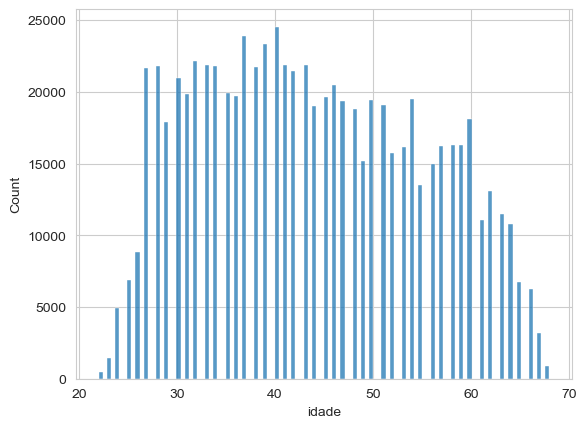

In [195]:
# Definindo as variáveis contínuas para análise
continuous_variables = ['idade', 'tempo_emprego', 'qtd_filhos']

sns.histplot(data_cleaned[continuous_variables[0]], kde=False)

<Axes: xlabel='tempo_emprego', ylabel='Count'>

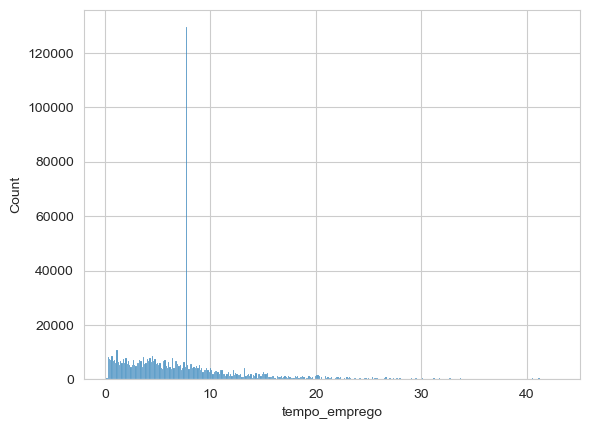

In [196]:
sns.histplot(data_cleaned[continuous_variables[1]], kde=False)

In [197]:

# Definindo os pontos de corte para as splines
knots_idade = [30, 40, 50, 60]
knots_tempo_emprego = [5, 10, 15, 20]

# Preparando as variáveis para o modelo, incluindo splines
# As variáveis categóricas são incluídas como estão
X = dmatrix("bs(idade, knots=knots_idade, degree=1) + bs(tempo_emprego, knots=knots_tempo_emprego, degree=1) + "
            "C(posse_de_veiculo) + C(posse_de_imovel) + (qtd_filhos) + C(tipo_renda) + "
            "C(educacao) + C(estado_civil) + C(tipo_residencia)", 
            data=train, return_type='dataframe')

# Variável alvo
y = train['renda_log']

# Criando o modelo de regressão
model = sm.OLS(y, X)
results = model.fit()

# Sumário do modelo
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:              renda_log   R-squared:                       0.393
Model:                            OLS   Adj. R-squared:                  0.392
Method:                 Least Squares   F-statistic:                 1.292e+04
Date:                Mon, 15 Jan 2024   Prob (F-statistic):               0.00
Time:                        19:48:14   Log-Likelihood:            -8.5207e+05
No. Observations:              600000   AIC:                         1.704e+06
Df Residuals:                  599969   BIC:                         1.705e+06
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                                                coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

shapiro_p_value= 2.7402864361647516e-05 
 skewness = -0.02087236550018651 
 kurtosis= -0.30351721231950846


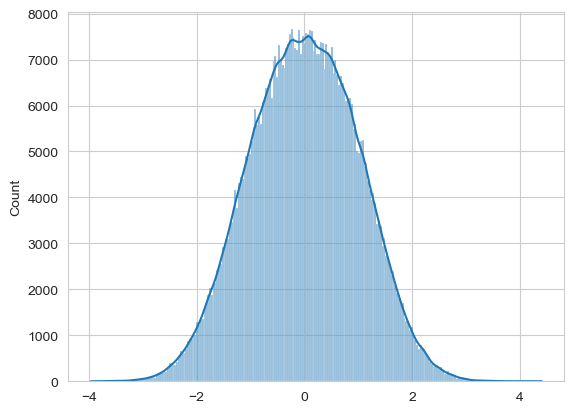

In [198]:
# Obtendo os resíduos do modelo
residuals = results.resid

# Plotando o histograma dos resíduos
sns.histplot(residuals, kde=True)

# Teste de Shapiro-Wilk para normalidade
shapiro_test = stats.shapiro(residuals.sample(5000))  # Amostra devido a limitações de tamanho
shapiro_p_value = shapiro_test.pvalue

# Testes de Skewness e Kurtosis
skewness = stats.skew(residuals)
kurtosis = stats.kurtosis(residuals)

print(f"shapiro_p_value= {shapiro_p_value} \n skewness = {skewness} \n kurtosis= {kurtosis}")


((array([-4.72417717, -4.54064159, -4.44130101, ...,  4.44130101,
          4.54064159,  4.72417717]),
  array([-3.96425125, -3.94917568, -3.94917568, ...,  4.40434051,
          4.40434051,  4.40434051])),
 (1.0005140545564661, -1.8547646072605348e-13, 0.9993233042080434))

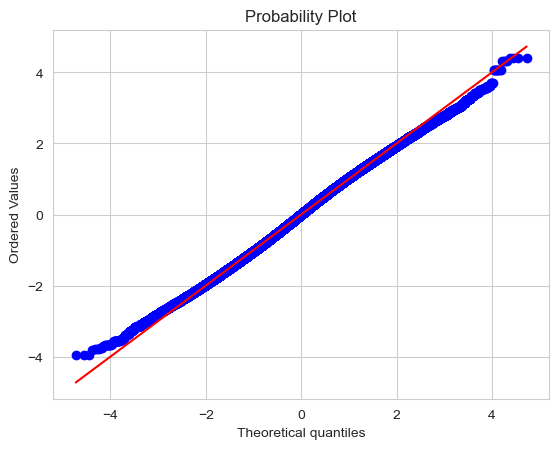

In [199]:
# Plotando o gráfico Q-Q
stats.probplot(residuals, dist="norm" , plot=plt)

Com base nesses resultados, podemos concluir que os resíduos do modelo não seguem exatamente uma distribuição normal, especialmente evidenciado pelo teste de Shapiro-Wilk e pelas discrepâncias observadas no gráfico Q-Q

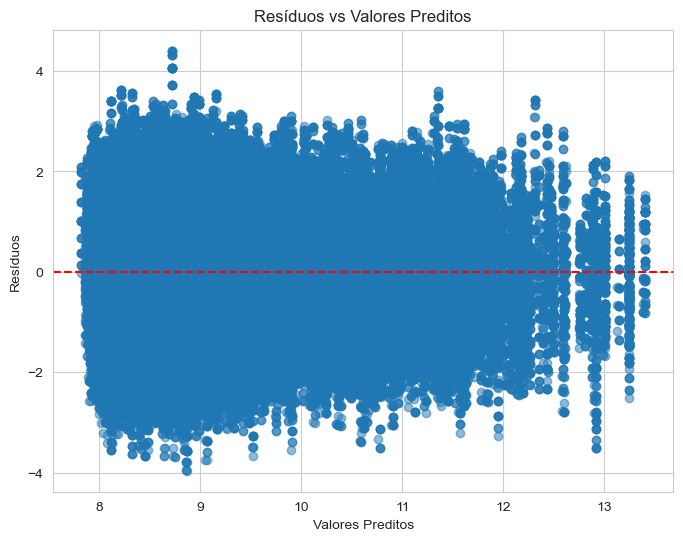

In [200]:
# Calculando os valores preditos
predicted_values = results.fittedvalues

# Plotando os resíduos versus os valores preditos
plt.figure(figsize=(8, 6))
plt.scatter(predicted_values, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Valores Preditos')
plt.ylabel('Resíduos')
plt.title('Resíduos vs Valores Preditos')
plt.show()

Não parece haver padrões claros ou estruturas nos resíduos, o que é um bom sinal. A dispersão dos resíduos parece razoavelmente constante em relação aos valores preditos, embora possa haver uma leve heterocedasticidade, como indicado por uma concentração de resíduos em torno de zero para valores preditos mais baixos.

ValueError: num must be an integer with 1 <= num <= 6, not 7

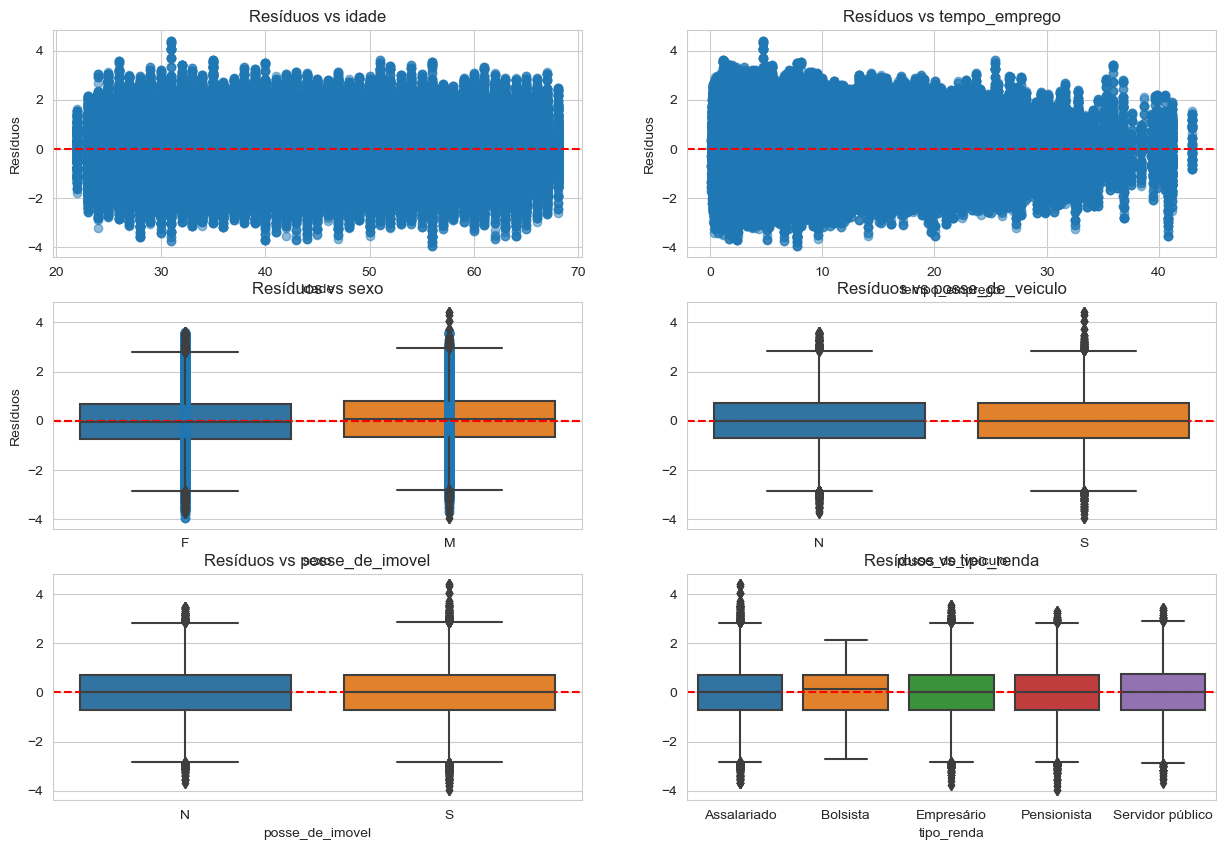

In [201]:
# Selecionando algumas variáveis categóricas chave para análise
categorical_variables_to_plot = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao']

# Criando gráficos para variáveis contínuas e categóricas chave
plt.figure(figsize=(15, 10))

# Variáveis contínuas
for i, var in enumerate(continuous_variables, 1):
    plt.subplot(3, 2, i)
    plt.scatter(train[var], residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel(var)
    plt.ylabel('Resíduos')
    plt.title(f'Resíduos vs {var}')

# Algumas variáveis categóricas
for i, var in enumerate(categorical_variables_to_plot, 1):
    plt.subplot(3, 2, i + 2)
    sns.boxplot(x=var, y=residuals, data=train)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title(f'Resíduos vs {var}')

plt.tight_layout()
plt.show()


ValueError: num must be an integer with 1 <= num <= 2, not 3

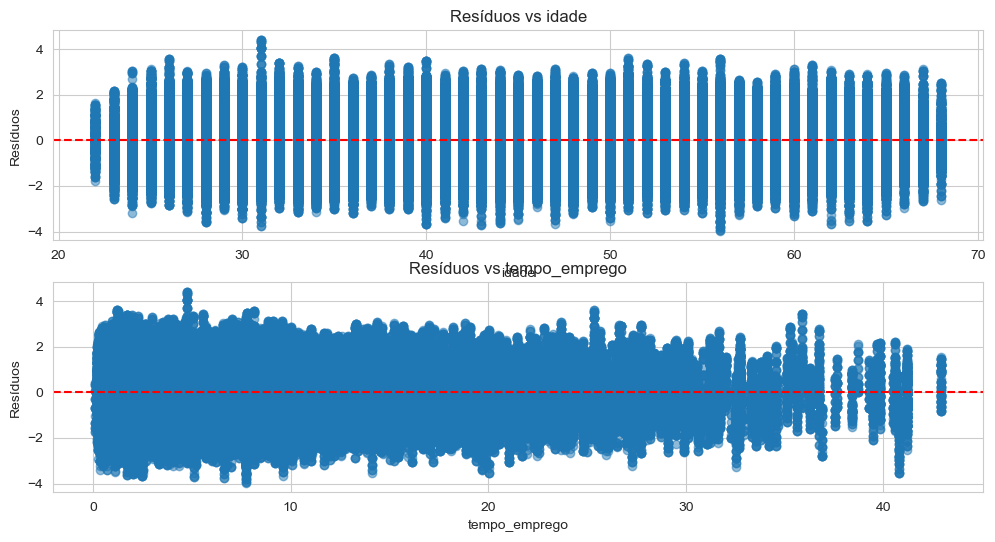

In [202]:
# Criando gráficos para as variáveis contínuas
plt.figure(figsize=(12, 6))

for i, var in enumerate(continuous_variables, 1):
    plt.subplot(2, 1, i)
    plt.scatter(train[var], residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel(var)
    plt.ylabel('Resíduos')
    plt.title(f'Resíduos vs {var}')

plt.tight_layout()
plt.show()


- Nos gráficos das variáveis categóricas, também não observamos padrões consistentes nos resíduos. As medianas dos resíduos estão próximas de zero em todas as categorias, e não há sinais evidentes de heterocedasticidade (variância dos resíduos variando entre as categorias).

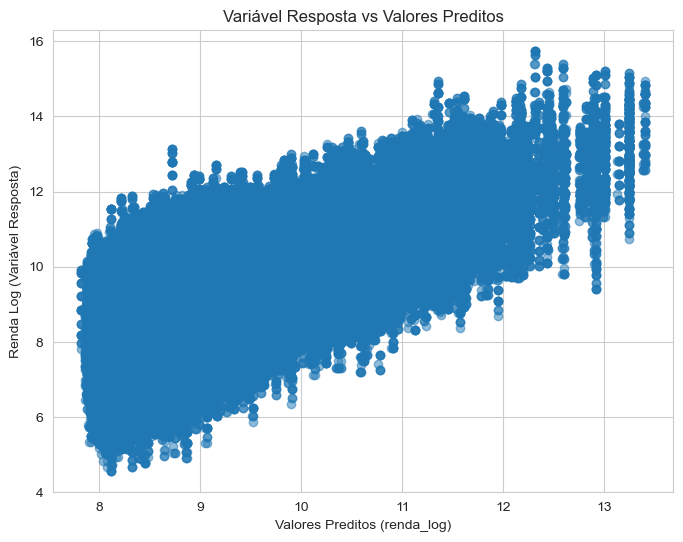

In [203]:
# Plotando a variável resposta versus os valores previstos
plt.figure(figsize=(8, 6))
plt.scatter(predicted_values, y, alpha=0.5)
plt.xlabel('Valores Preditos (renda_log)')
plt.ylabel('Renda Log (Variável Resposta)')
plt.title('Variável Resposta vs Valores Preditos')
plt.show()


Ao avaliar um modelo de regressão linear, como o que foi construído, é importante considerar várias suposições-chave. Vamos revisar como essas suposições foram atendidas no seu modelo e discutir o impacto de eventuais desvios:

1. **Linearidade**: A relação entre as variáveis independentes e a variável dependente deve ser linear. Isso foi abordado pelo uso de splines em algumas variáveis, o que ajuda a modelar relações não-lineares.

2. **Independência dos Erros**: Os resíduos (erros) devem ser independentes. Não avaliamos isso diretamente, mas a ausência de padrões nos gráficos de resíduos sugere que não há problemas óbvios.

3. **Homocedasticidade**: A variância dos resíduos deve ser constante. Os gráficos de resíduos vs valores previstos e a variável resposta vs valores previstos não mostraram sinais claros de heterocedasticidade, o que é positivo.

4. **Normalidade dos Resíduos**: Idealmente, os resíduos devem seguir uma distribuição normal. No entanto, encontramos desvios da normalidade. Embora isso não invalide o modelo, pode afetar a confiabilidade de certos testes estatísticos, como os testes de hipóteses para os coeficientes.

5. **Ausência de Multicolinearidade**: Em modelos com múltiplas variáveis independentes, é importante que elas não sejam altamente correlacionadas. Não avaliamos isso diretamente, mas técnicas como VIF (Variance Inflation Factor) podem ser usadas para verificar.

### Impacto dos Desvios:

- **Desvios da Normalidade dos Resíduos**: Isso pode tornar menos confiáveis os testes de significância estatística dos coeficientes. Em grandes amostras, como a sua, esse impacto é geralmente reduzido devido ao Teorema do Limite Central.

- **Outras Suposições**: Se houvesse problemas significativos com homocedasticidade ou independência dos erros, isso poderia afetar a confiabilidade das previsões e dos intervalos de confiança.

Em resumo, o modelo parece razoavelmente robusto, embora a normalidade dos resíduos não seja ideal. Em muitos casos práticos, especialmente com grandes conjuntos de dados, pequenos desvios das suposições podem ser aceitáveis. Contudo, é sempre importante considerar o contexto específico e a finalidade da modelagem ao avaliar a adequação do modelo.

## Outliers

Avalie os *studentized residuals*, verifique se há pontos que parecem ser discrepantes.

Avalie se há pontos influentes.

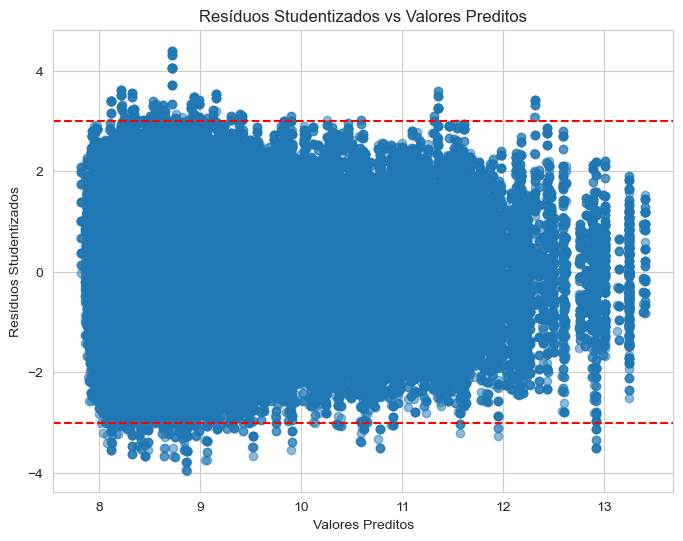

Quantidade de outliers:  682


In [204]:
# Calculando os resíduos studentizados
test = OLSInfluence(results)
studentized_residuals = test.resid_studentized_internal

# Plotando os resíduos studentizados
plt.figure(figsize=(8, 6))
plt.scatter(predicted_values, studentized_residuals, alpha=0.5)
plt.axhline(y=3, color='r', linestyle='--')
plt.axhline(y=-3, color='r', linestyle='--')
plt.xlabel('Valores Preditos')
plt.ylabel('Resíduos Studentizados')
plt.title('Resíduos Studentizados vs Valores Preditos')
plt.show()

# Verificando a quantidade de pontos com resíduos studentizados maiores que 3 em valor absoluto
outliers = sum(abs(studentized_residuals) > 3)
print("Quantidade de outliers: ", outliers)


## Multicolinearidade

Avalie se há questões relacionadas a multicolinearidade através de pelo menos:

- Matriz de correlação de Spearman
- VIF

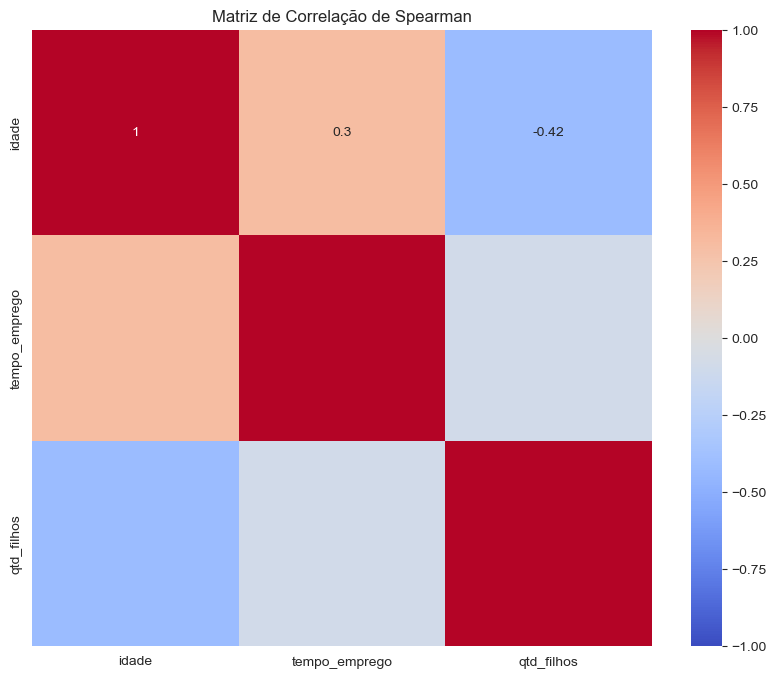

In [205]:
# Calculando a matriz de correlação de Spearman para as variáveis independentes
spearman_corr = data_cleaned[continuous_variables].corr(method='spearman')

# Plotando a matriz de correlação
plt.figure(figsize=(10, 8))
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de Correlação de Spearman')
plt.show()


In [206]:
# 'X' é seu dataframe com variáveis independentes
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data.sort_values(by="VIF", ascending=False))


                                              feature         VIF
0                                           Intercept  236.239716
7                                C(educacao)[T.Médio]   21.644670
9                    C(educacao)[T.Superior completo]   20.836813
20          bs(idade, knots=knots_idade, degree=1)[0]   10.386031
21          bs(idade, knots=knots_idade, degree=1)[1]    8.213907
22          bs(idade, knots=knots_idade, degree=1)[2]    8.146677
23          bs(idade, knots=knots_idade, degree=1)[3]    8.118136
15                         C(tipo_residencia)[T.Casa]    6.791580
10                 C(educacao)[T.Superior incompleto]    4.360952
16                  C(tipo_residencia)[T.Com os pais]    4.085267
19                C(tipo_residencia)[T.Governamental]    3.207627
5                        C(tipo_renda)[T.Pensionista]    2.854316
24          bs(idade, knots=knots_idade, degree=1)[4]    2.709812
25  bs(tempo_emprego, knots=knots_tempo_emprego, d...    2.051734
26  bs(tem

## Ajustes

Faça os ajustes que julgar necessários no modelo e compare as métricas de desempenho do modelo original e ajustado na base de testes.

In [208]:
# Convertendo as colunas especificadas para o tipo 'category'
categorical_columns = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia']
data_cleaned[categorical_columns] = data_cleaned[categorical_columns].astype('category')

# Criando as variáveis dummy para as variáveis categóricas
data_cleaned = pd.get_dummies(data_cleaned, columns=categorical_columns, drop_first=True)

In [238]:
# Excluindo as colunas menos relevantes, de acordo com o VIF
data_best_variables = data_cleaned.drop(columns=['idade', 'educacao_Superior completo', 'educacao_Médio', 'tipo_residencia_Casa', 'tipo_residencia_Governamental', 'tipo_residencia_Com os pais','renda', 'data_ref', 'sexo_M'])

data_best_variables.describe()

,qtd_filhos,tempo_emprego,qt_pessoas_residencia,renda_log,posse_de_veiculo_S,posse_de_imovel_S,tipo_renda_Bolsista,tipo_renda_Empresário,tipo_renda_Pensionista,tipo_renda_Servidor público,educacao_Pós graduação,educacao_Superior incompleto,estado_civil_Separado,estado_civil_Solteiro,estado_civil_União,estado_civil_Viúvo,tipo_residencia_Comunitário,tipo_residencia_Estúdio
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,0.433267,7.746165,2.212315,9.042811,0.389763,0.671313,0.000503,0.230143,0.168096,0.086691,0.001068,0.039417,0.056685,0.122323,0.077255,0.042032,0.004373,0.007251
std,0.738516,6.098082,0.903041,1.284197,0.487697,0.469736,0.022415,0.420924,0.373952,0.281381,0.032663,0.194586,0.231241,0.327658,0.266995,0.200662,0.065986,0.084842
min,0.000000,0.117808,1.000000,4.557030,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,3.635616,2.000000,8.151728,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,7.471233,2.000000,8.978406,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,9.093151,3.000000,9.833449,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,14.000000,42.906849,15.000000,15.732766,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [237]:
# Excluir Outliers
def remove_outliers(df):
    num_cols = df.select_dtypes(include=[np.number]).columns
    for col in num_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 3 * IQR
        upper_bound = Q3 + 3 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

data_without_outliers = remove_outliers(df=data_best_variables)
data_without_outliers.describe()

,qtd_filhos,tempo_emprego,qt_pessoas_residencia,renda_log,posse_de_veiculo_S,posse_de_imovel_S,tipo_renda_Bolsista,tipo_renda_Empresário,tipo_renda_Pensionista,tipo_renda_Servidor público,educacao_Pós graduação,educacao_Superior incompleto,estado_civil_Separado,estado_civil_Solteiro,estado_civil_União,estado_civil_Viúvo,tipo_residencia_Comunitário,tipo_residencia_Estúdio
count,256067.000000,256067.000000,256067.000000,256067.000000,256067.000000,256067.000000,256067.0,256067.0,256067.0,256067.0,256067.0,256067.0,256067.0,256067.0,256067.0,256067.0,256067.0,256067.0
mean,0.592419,7.177781,2.591138,8.977358,0.477555,0.663315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.814272,5.390576,0.814843,1.220890,0.499497,0.472577,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.000000,0.117808,1.000000,4.557030,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.000000,3.084932,2.000000,8.119565,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.000000,5.994521,2.000000,8.948339,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,1.000000,9.893151,3.000000,9.787757,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,4.000000,25.364384,6.000000,14.610848,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [239]:
# Excluindo as colunas com somente um valor
data_best_variables = data_cleaned.drop(columns=['tipo_renda_Bolsista', 'tipo_renda_Empresário', 'tipo_renda_Pensionista', 'tipo_renda_Servidor público', 'educacao_Pós graduação', 'educacao_Superior incompleto','renda', 'data_ref', 'sexo_M', 'estado_civil_Separado', 'estado_civil_Solteiro', 'estado_civil_União', 'estado_civil_Viúvo', 'tipo_residencia_Comunitário', 'tipo_residencia_Estúdio'])

data_best_variables.describe()

,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda_log,posse_de_veiculo_S,posse_de_imovel_S,educacao_Médio,educacao_Superior completo,tipo_residencia_Casa,tipo_residencia_Com os pais,tipo_residencia_Governamental
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,0.433267,43.796907,7.746165,2.212315,9.042811,0.389763,0.671313,0.597132,0.351003,0.898739,0.044399,0.031327
std,0.738516,11.229454,6.098082,0.903041,1.284197,0.487697,0.469736,0.490475,0.477284,0.301675,0.205979,0.174199
min,0.000000,22.000000,0.117808,1.000000,4.557030,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,34.000000,3.635616,2.000000,8.151728,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,0.000000,43.000000,7.471233,2.000000,8.978406,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000
75%,1.000000,53.000000,9.093151,3.000000,9.833449,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
max,14.000000,68.000000,42.906849,15.000000,15.732766,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [240]:
# Separando a base de treino e teste
X_train, X_test, y_train, y_test = train_test_split(data_without_outliers.drop(columns=['renda_log']), data_without_outliers['renda_log'], test_size=0.15)


# Inicializando o modelo Ridge com um valor específico de alpha
ridge = Ridge(alpha=0.5)

# Treinando o modelo
ridge.fit(X_train, y_train)

# Fazendo previsões
y_pred = ridge.predict(X_test)

# Avaliando o modelo
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R2:", r2_score(y_test, y_pred))

Mean Squared Error: 0.9930523612350213
R2: 0.32624753653758587


In [241]:
# Repetindo o processo para a base de dados com outliers

X_train, X_test, y_train, y_test = train_test_split(data_best_variables.drop(columns=['renda_log']), data_best_variables['renda_log'], test_size=0.15)


# Inicializando o modelo Ridge com um valor específico de alpha
ridge = Ridge(alpha=0.5)

# Treinando o modelo
ridge.fit(X_train, y_train)

# Fazendo previsões
y_pred = ridge.predict(X_test)

# Avaliando o modelo
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R2:", r2_score(y_test, y_pred))

Mean Squared Error: 1.0182174543667342
R2: 0.3806477150616794


In [242]:
# Usando somente a variável tempo_emprego
X_train, X_test, y_train, y_test = train_test_split(data_without_outliers['tempo_emprego'], data_without_outliers['renda_log'], test_size=0.15)

# Inicializando o modelo Ridge com um valor específico de alpha
ridge = Ridge(alpha=0.5)

# Treinando o modelo
ridge.fit(X_train.values.reshape(-1, 1), y_train)

# Fazendo previsões
y_pred = ridge.predict(X_test.values.reshape(-1, 1))

# Avaliando o modelo
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R2:", r2_score(y_test, y_pred))

Mean Squared Error: 1.0100239319271413
R2: 0.3228773280410845


In [243]:
# Usando somente a variável tempo_emprego
X_train, X_test, y_train, y_test = train_test_split(data_best_variables['tempo_emprego'], data_best_variables['renda_log'], test_size=0.15)

# Inicializando o modelo Ridge com um valor específico de alpha
ridge = Ridge(alpha=0.5)

# Treinando o modelo
ridge.fit(X_train.values.reshape(-1, 1), y_train)

# Fazendo previsões
y_pred = ridge.predict(X_test.values.reshape(-1, 1))

# Avaliando o modelo
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R2:", r2_score(y_test, y_pred))

Mean Squared Error: 1.0300186176013053
R2: 0.37812947573610867


## Conclusão
- O melhor modelo foi gerado com base na Regressão segmentada (Splines) nos dados com um $R^2$ de 0.39
- Os ajustes nos dados como a remoção de variávéis com VIF alto e a remoção de outliers não melhoraram o modelo